# PES_1D-Discriminator

In [6]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from pes_1D.data_generator import generate_discriminator_training_set  # type: ignore
from pes_1D.discriminator import AnnDiscriminator  # type: ignore
from pes_1D.training import test_model, train_model  # type: ignore
from pes_1D.utils import get_model_failure_info  # type: ignore
from pes_1D.visualization import sample_visualization   # type: ignore

### parameters

In [7]:
number_of_pts = 128
n_samples = 10000
test_split = 0.4
gpu = True

properties_list = ["energy","derivative","inverse_derivative"]  # List of properties to use for training
properties_format = "array"  # Format [concatenated array or table] of properties to use for training
deformation_list = np.array(["outliers","oscillation"])  # Types of deformation to generate


### Generate training and test sets 

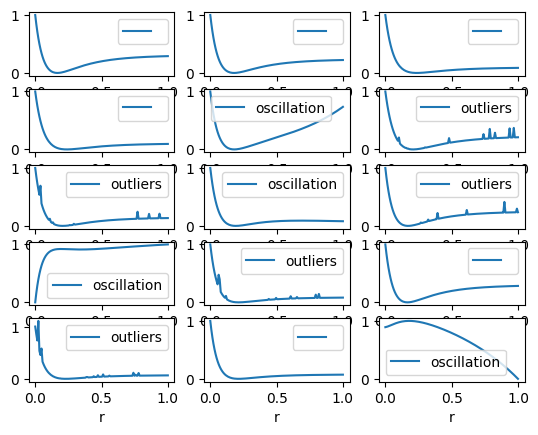

In [8]:
X_train, y_train, X_test, y_test, df_samples = generate_discriminator_training_set(
    n_samples, number_of_pts,
    properties_list,
    deformation_list,
    properties_format,
    test_split, gpu, 
    generator_seed=[37, 43]
)

# define number of input features
in_features = X_train.shape[1] if properties_format == "array" else number_of_pts

sample_visualization(df_samples)

### Discriminator model definition

In [12]:
model =  AnnDiscriminator(in_features, [512,128,32], 2)
model = model.to("cuda" if gpu else "cpu") 


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

### Train the model

Training the model...
Training Losses:0.11726556718349457


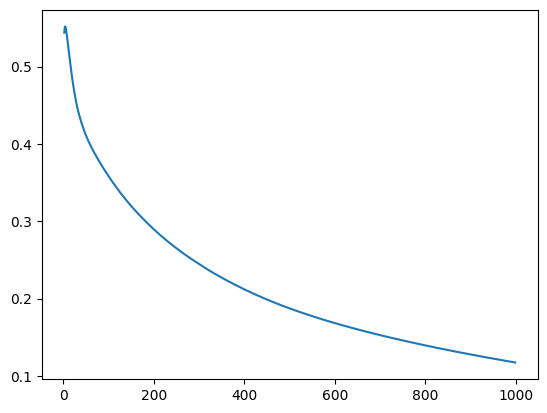

Evaluation:
Test Loss: 0.11718378961086273
Accuracy (%):  97.025


In [13]:
epochs = 1000

# Train the model
print("Training the model...")
losses = train_model(X_train, y_train, model, criterion, optimizer, epochs,verbose=False)

print(f"Training Losses:{losses[-1]}")
plt.plot(range(2,epochs), losses[2:])
plt.show()


# Test the model
test_loss, accuracy = test_model(X_test, y_test, model, criterion)


### Get model failure information

Confusion Matrix:  Confusion Matrix
[[1879   81]
 [  38 2002]]


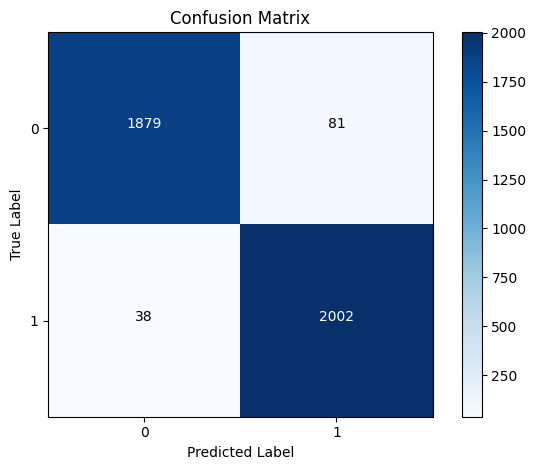



Failure Distribution by Deformation Type:
deformation_type
oscillation    78
               38
outliers        3
Name: count, dtype: int64




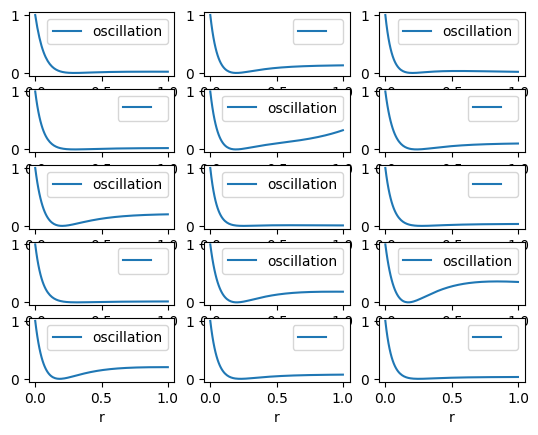

In [14]:
df_train = df_samples[df_samples.index < n_samples - int(n_samples * test_split)]
df_test = df_samples[df_samples.index >= n_samples - int(n_samples * test_split)]


get_model_failure_info(df_test, X_test, y_test, model)